<a href="https://colab.research.google.com/github/Yeonjoon-Kim/gnn_demo/blob/main/logS_pred_GNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Inspired by and modified from this colab notebook:

https://colab.research.google.com/github/pstjohn/gnn-codecamp/blob/main/cetane_number_prediction.ipynb

# Graph Neural Networks (GNNs) and molecular property prediction

## Enabling the GPU (Google Colab)

To enable GPUs for the notebook:

- Navigate to Edit→Notebook Settings
- Select GPU from the Hardware Accelerator drop-down

# Linear regression and multi-layer perceptron

In [ ]:
!pip install rdkit-pypi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 21.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd

import rdkit
from rdkit.Chem import AllChem

In [ ]:
logS_data = pd.read_csv('AqsolDB_CHO.csv')
logS_data.head()

,ID,Name,InChI,InChIKey,SMILES,Solubility,SD,Ocurrences,Group,MolWt,...,NumValenceElectrons,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,RingCount,TPSA,LabuteASA,BalabanJ,BertzCT,delete?
0,A-10,vinyltoluene,"InChI=1S/C9H10/c1-3-9-6-4-5-8(2)7-9/h3-7H,1H2,2H3",JZHGRUMIRATHIU-UHFFFAOYSA-N,Cc1cccc(C=C)c1,-3.123150,0.000000,1,G1,118.179,...,46.0,1.0,0.0,0.0,1.0,0.00,55.836626,3.070761,211.033225,False
1,A-11,3-(3-ethylcyclopentyl)propanoic acid,InChI=1S/C10H18O2/c1-2-8-3-4-9(7-8)5-6-10(11)1...,WVRFSLWCFASCIS-UHFFFAOYSA-N,CCC1CCC(CCC(O)=O)C1,-3.286116,0.000000,1,G1,170.252,...,70.0,0.0,1.0,1.0,1.0,37.30,73.973655,2.145839,153.917569,False
2,A-12,"11,16,17,21-tetrahydroxypregna-1,4-diene-3,20-...",InChI=1S/C21H28O6/c1-19-6-5-12(23)7-11(19)3-4-...,SEKYBDYVXDAYPY-UHFFFAOYSA-N,CC12CC(O)C3C(CCC4=CC(=O)C=CC34C)C1CC(O)C2(O)C(...,-2.664549,0.000000,1,G1,376.449,...,148.0,0.0,3.0,4.0,4.0,115.06,158.135542,1.776978,755.770792,False
3,A-15,1-[2-(benzoyloxy)propoxy]propan-2-yl benzoate ...,InChI=1S/C20H22O5/c21-19(17-9-3-1-4-10-17)24-1...,BYQDGAVOOHIJQS-UHFFFAOYSA-N,O=C(OCCCOCCCOC(=O)c1ccccc1)c2ccccc2,-4.595503,0.118551,2,G3,342.391,...,132.0,2.0,0.0,0.0,2.0,61.83,147.071714,1.447050,582.150793,False
4,A-18,2-methyl-1-phenylpropan-2-yl acetate,"InChI=1S/C12H16O2/c1-10(13)14-12(2,3)9-11-7-5-...",FLUWAIIVLCVEKF-UHFFFAOYSA-N,CC(=O)OC(C)(C)Cc1ccccc1,-2.394650,0.000000,1,G1,192.258,...,76.0,1.0,0.0,0.0,1.0,26.30,84.896123,2.633870,301.357585,False


<Axes: ylabel='Frequency'>

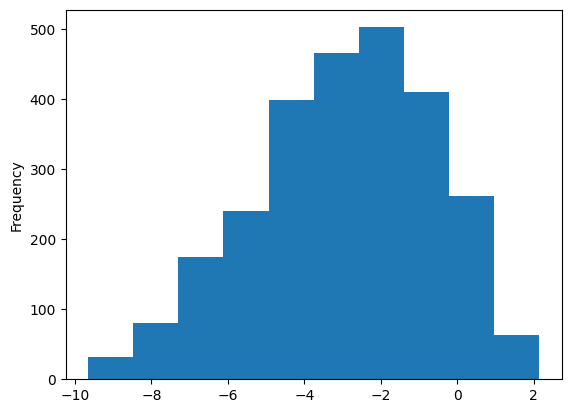

In [ ]:
logS_data.Solubility.plot.hist()

In [ ]:
logS_test = logS_data.sample(frac=0.2, random_state=42)
logS_train = logS_data[~logS_data.index.isin(logS_test.index)]

In [ ]:
def get_morgan_fingerprint(smiles, radius=2, nBits=1024):
  mol = rdkit.Chem.MolFromSmiles(smiles)
  bv = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits)
  return np.asarray(bv)

def get_all_fingerprints(smiles_series):
  fingerprints = np.vstack(smiles_series.apply(get_morgan_fingerprint).values)
  return fingerprints

In [ ]:
fingerprints_train = get_all_fingerprints(logS_train.SMILES)
fingerprints_test = get_all_fingerprints(logS_test.SMILES)

### First, try a simple linear regression (using scikit-learn)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

linear_model = make_pipeline(PCA(n_components=25, whiten=True), LinearRegression())

linear_model.fit(fingerprints_train, logS_train.Solubility)
logS_test_pred = linear_model.predict(fingerprints_test)

In [ ]:
(logS_test_pred - logS_test.Solubility).abs().mean()

1.1954016378010626

### Next, let's try a simple Multi-layer perceptron

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
tf.__version__

'2.14.0'

In [ ]:
input = layers.Input(shape=(1024), name='fingerprint', dtype='int64')
out = layers.Dense(128, activation='relu')(input)
out = layers.BatchNormalization()(out)
out = layers.Dense(64, activation='relu')(out)
out = layers.BatchNormalization()(out)
out = layers.Dense(1)(out)

mlp_model = tf.keras.Model(input, out)

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=1E-2)
mlp_model.compile(optimizer=opt, loss='mae')

In [ ]:
hist = mlp_model.fit(x=fingerprints_train, y=logS_train.Solubility,
                     validation_data=(fingerprints_test, logS_test.Solubility),
                     epochs=30, batch_size=32, verbose=2)

Epoch 1/30
66/66 - 7s - loss: 1.6195 - val_loss: 1.4812 - 7s/epoch - 103ms/step
Epoch 2/30
66/66 - 0s - loss: 0.9936 - val_loss: 1.0780 - 321ms/epoch - 5ms/step
Epoch 3/30
66/66 - 0s - loss: 0.8301 - val_loss: 0.9513 - 320ms/epoch - 5ms/step
Epoch 4/30
66/66 - 0s - loss: 0.8214 - val_loss: 0.9080 - 302ms/epoch - 5ms/step
Epoch 5/30
66/66 - 0s - loss: 0.7490 - val_loss: 1.0280 - 288ms/epoch - 4ms/step
Epoch 6/30
66/66 - 0s - loss: 0.7451 - val_loss: 0.8637 - 314ms/epoch - 5ms/step
Epoch 7/30
66/66 - 0s - loss: 0.6941 - val_loss: 1.0225 - 331ms/epoch - 5ms/step
Epoch 8/30
66/66 - 0s - loss: 0.6494 - val_loss: 0.9180 - 288ms/epoch - 4ms/step
Epoch 9/30
66/66 - 0s - loss: 0.6473 - val_loss: 0.8892 - 288ms/epoch - 4ms/step
Epoch 10/30
66/66 - 0s - loss: 0.6454 - val_loss: 0.9041 - 298ms/epoch - 5ms/step
Epoch 11/30
66/66 - 0s - loss: 0.6747 - val_loss: 0.9822 - 304ms/epoch - 5ms/step
Epoch 12/30
66/66 - 0s - loss: 0.6476 - val_loss: 0.9199 - 283ms/epoch - 4ms/step
Epoch 13/30
66/66 - 0s - l

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

<Axes: >

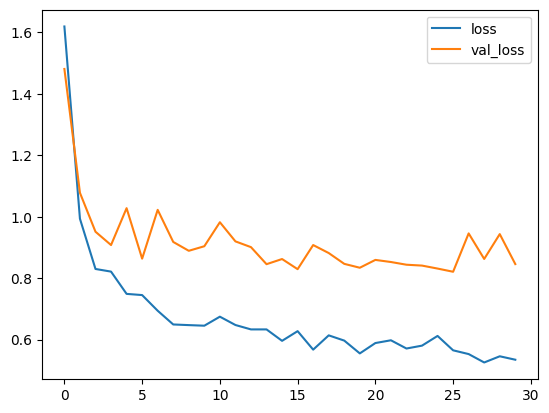

In [ ]:
pd.DataFrame(hist.history).plot.line()

In [ ]:
mlp_model.predict(get_morgan_fingerprint('CC(C)COCC(C)C').reshape(1, -1))

1/1 [==============================] - 0s 99ms/step


array([[-1.2657049]], dtype=float32)

## Creating a GNN
First, we need to install our GNN dependency [nfp](github.com/nrel/nfp)

In [ ]:
!pip install nfp==0.3.0

Define how we want to featurize atoms and bonds

In [ ]:
import nfp
from collections import namedtuple

atom_type = namedtuple('Atom', ['symbol', 'aromatic', 'ring_size', 'degree', 'totalHs'])
bond_type = namedtuple('Bond', ['bond_type', 'degree', 'ring_size'])

def atom_featurizer(atom):
    """ Return an string representing the atom type
    """

    return atom_type(
        atom.GetSymbol(),
        atom.GetIsAromatic(),
        nfp.get_ring_size(atom, max_size=6),
        atom.GetDegree(),
        atom.GetTotalNumHs(includeNeighbors=True)
    )

def bond_featurizer(bond, flipped=False):
    """ Get a similar classification of the bond type.
    Flipped indicates which 'direction' the bond edge is pointing. """

    if not flipped:
        atoms = "{}-{}".format(
            *tuple((bond.GetBeginAtom().GetSymbol(),
                    bond.GetEndAtom().GetSymbol())))
    else:
        atoms = "{}-{}".format(
            *tuple((bond.GetEndAtom().GetSymbol(),
                    bond.GetBeginAtom().GetSymbol())))

    btype = str(bond.GetBondType())
    ring = nfp.get_ring_size(bond, max_size=6) if bond.IsInRing() else None

    return bond_type(atoms, btype, ring)

In [ ]:
mol = rdkit.Chem.MolFromSmiles('CC(C)COCC(C)C')

In [ ]:
atom_featurizer(mol.GetAtoms()[0])

Atom(symbol='C', aromatic=False, ring_size=0, degree=1, totalHs=3)

In [ ]:
bond_featurizer(mol.GetBonds()[0])

Bond(bond_type='C-C', degree='SINGLE', ring_size=None)

In [ ]:
preprocessor = nfp.SmilesPreprocessor(atom_features=atom_featurizer,
                                      bond_features=bond_featurizer,
                                      explicit_hs=False)

In [ ]:
pd.Series(preprocessor.atom_tokenizer._data)

unk    1
dtype: int64

In [ ]:
for smiles in logS_train.SMILES:
  preprocessor.construct_feature_matrices(smiles, train=True)

In [ ]:
pd.Series(preprocessor.atom_tokenizer._data)

unk                       1
(C, False, 0, 1, 3)       2
(C, True, max, 3, 0)      3
(C, True, max, 2, 1)      4
(C, False, 0, 2, 1)       5
(C, False, 0, 1, 2)       6
(C, False, 0, 2, 2)       7
(C, False, 5, 3, 1)       8
(C, False, 5, 2, 2)       9
(C, False, 0, 3, 0)      10
(O, False, 0, 1, 1)      11
(O, False, 0, 1, 0)      12
(C, False, 5, 4, 0)      13
(C, False, max, 2, 2)    14
(C, False, max, 3, 1)    15
(C, False, max, 3, 0)    16
(C, False, max, 2, 1)    17
(C, False, max, 4, 0)    18
(O, False, 0, 2, 0)      19
(C, False, 0, 4, 0)      20
(C, False, 3, 3, 1)      21
(C, False, 3, 2, 2)      22
(O, False, 3, 2, 0)      23
(C, False, 0, 3, 1)      24
(C, False, 4, 4, 0)      25
(C, False, 4, 3, 1)      26
(C, False, 4, 2, 2)      27
(C, False, 3, 4, 0)      28
(C, True, 5, 3, 0)       29
(O, False, 5, 2, 0)      30
(C, False, 5, 3, 0)      31
(O, True, max, 2, 0)     32
(O, False, max, 2, 0)    33
(C, False, 0, 2, 0)      34
(C, False, 0, 1, 1)      35
(C, False, 5, 2, 1) 

In [ ]:
preprocessor.construct_feature_matrices('CCO', train=False)['atom']

array([ 2,  7, 11], dtype=int32)

In [ ]:
preprocessor.construct_feature_matrices('CCO', train=False)['bond']

array([2, 2, 6, 8], dtype=int32)

In [ ]:
preprocessor.construct_feature_matrices('CCO', train=False)['connectivity']

array([[0, 1],
       [1, 0],
       [1, 2],
       [2, 1]], dtype=int32)

We can use tensorflow's [`Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) methods to speedup and "simplify" some of these transformation operations. The easiest way to initialize these is from a python generator.

In [ ]:
def data_generator(logS_split):
  for _, row in logS_split.iterrows():
    inputs = preprocessor.construct_feature_matrices(row.SMILES, train=False)
    yield ({'atom': inputs['atom'],
            'bond': inputs['bond'],
            'connectivity': inputs['connectivity']},
           row.Solubility)

output_signature = (preprocessor.output_signature,
                    tf.TensorSpec(shape=(), dtype=tf.float32))

In [ ]:
train_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(logS_train),
    output_signature=output_signature)\
    .cache().shuffle(buffer_size=200)\
    .padded_batch(batch_size=32)\
    .prefetch(tf.data.experimental.AUTOTUNE)

valid_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(logS_test),
    output_signature=output_signature)\
    .cache().shuffle(buffer_size=200)\
    .padded_batch(batch_size=32)\
    .prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
# extract inputs, outputs from one batch (32 data points)
for inputs, outputs in train_dataset.as_numpy_iterator():
  break

inputs['atom']

array([[ 2,  7, 10, ...,  0,  0,  0],
       [ 2,  3,  4, ...,  0,  0,  0],
       [ 2, 19, 18, ...,  0,  0,  0],
       ...,
       [ 2,  7,  3, ...,  4,  4,  4],
       [ 2, 19, 15, ...,  0,  0,  0],
       [ 2,  7, 19, ...,  0,  0,  0]], dtype=int32)

In [ ]:
outputs

array([-3.5585928, -1.3879839, -4.740177 , -4.6267486, -3.9515188,
       -2.4116683, -3.4953597, -2.8265355, -2.5936885, -2.7727895,
       -2.6568928, -4.5985985, -2.4091287, -2.478579 , -0.6030114,
       -4.1510887, -2.9776042, -1.3829101, -4.952869 , -3.5976238,
       -3.5540595, -1.6471415, -1.4057515, -3.3940628, -1.2199585,
       -2.6942897, -3.430239 , -3.2861164, -2.6532063, -4.5881767,
       -4.6835904, -2.4548998], dtype=float32)

Specifying our GNN using the [tf.keras functional api](https://www.tensorflow.org/guide/keras/functional). There's several alternative ways we could do this

In [ ]:
atom = layers.Input(shape=[None], dtype=tf.int32, name='atom')
bond = layers.Input(shape=[None], dtype=tf.int32, name='bond')
connectivity = layers.Input(shape=[None, 2], dtype=tf.int32, name='connectivity')


num_features = 128

atom_state = layers.Embedding(preprocessor.atom_classes, num_features,
                              name='atom_embedding', mask_zero=True)(atom)

bond_state = layers.Embedding(preprocessor.bond_classes, num_features,
                              name='bond_embedding', mask_zero=True)(bond)

atom_mean = layers.Embedding(preprocessor.atom_classes, 1,
                             name='atom_mean', mask_zero=True)(atom)

for _ in range(6):
  new_bond_state = nfp.EdgeUpdate()([atom_state, bond_state, connectivity])
  bond_state = layers.Add()([bond_state, new_bond_state])

  new_atom_state = nfp.NodeUpdate()([atom_state, bond_state, connectivity])
  atom_state = layers.Add()([atom_state, new_atom_state])

atomwise_prediction = layers.Dense(1)(atom_state)
atomwise_prediction = layers.Add()([atomwise_prediction, atom_mean])
mol_prediction = layers.GlobalAveragePooling1D()(atomwise_prediction)

gnn_model = tf.keras.Model([atom, bond, connectivity], [mol_prediction])

In [ ]:
!pip install -U tensorflow-addons
import tensorflow_addons as tfa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 6.9 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
optimizer = tfa.optimizers.AdamW(learning_rate=1E-4, weight_decay=1E-5)
gnn_model.compile(optimizer, loss='mae')

In [ ]:
hist = gnn_model.fit(train_dataset, validation_data=valid_dataset, epochs=50, verbose=2)

Epoch 1/50
66/66 - 20s - loss: 1.5075 - val_loss: 1.2937 - 20s/epoch - 298ms/step
Epoch 2/50
66/66 - 4s - loss: 1.2331 - val_loss: 1.0937 - 4s/epoch - 58ms/step
Epoch 3/50
66/66 - 3s - loss: 1.0364 - val_loss: 0.9888 - 3s/epoch - 39ms/step
Epoch 4/50
66/66 - 3s - loss: 0.9352 - val_loss: 0.8745 - 3s/epoch - 38ms/step
Epoch 5/50
66/66 - 3s - loss: 0.8822 - val_loss: 0.8767 - 3s/epoch - 39ms/step
Epoch 6/50
66/66 - 3s - loss: 0.8182 - val_loss: 0.8403 - 3s/epoch - 43ms/step
Epoch 7/50
66/66 - 3s - loss: 0.7624 - val_loss: 0.7350 - 3s/epoch - 40ms/step
Epoch 8/50
66/66 - 3s - loss: 0.7099 - val_loss: 0.8046 - 3s/epoch - 39ms/step
Epoch 9/50
66/66 - 3s - loss: 0.7411 - val_loss: 0.7303 - 3s/epoch - 49ms/step
Epoch 10/50
66/66 - 3s - loss: 0.7335 - val_loss: 0.7612 - 3s/epoch - 39ms/step
Epoch 11/50
66/66 - 3s - loss: 0.6861 - val_loss: 0.7865 - 3s/epoch - 40ms/step
Epoch 12/50
66/66 - 3s - loss: 0.6657 - val_loss: 0.6952 - 3s/epoch - 48ms/step
Epoch 13/50
66/66 - 3s - loss: 0.6708 - val_lo

<Axes: >

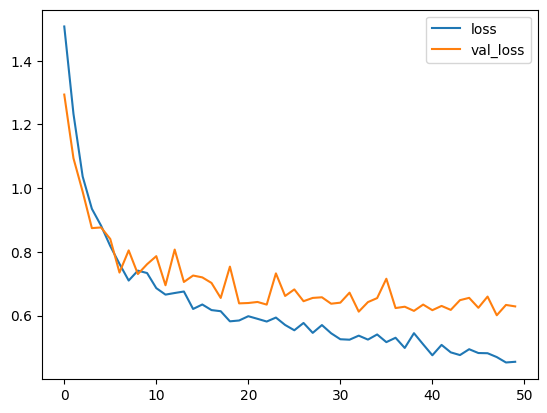

In [ ]:
pd.DataFrame(hist.history).plot.line()

In [ ]:
inputs = preprocessor.construct_feature_matrices('CC(C)COCC(C)C')
gnn_model.predict({key: np.expand_dims(inputs[key], axis=0) for key in ['atom', 'bond', 'connectivity']})

1/1 [==============================] - 2s 2s/step


array([[-2.1069276]], dtype=float32)